# Notebook for creating 75 km hail grid days using SPC hail reports

### Import libraries

In [1]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy import ndimage
from matplotlib import cm
from matplotlib.path import Path
import matplotlib.colors as colors
#from mpl_toolkits.basemap import Basemap, maskoceans
from scipy import stats
import xarray as xr
import datetime
import shapefile
#import regionmask
haz, siz = 'hail' , '1'

## Read in WRF lat/lon coords to find min/max lat/lons (match these values to lat/lon min/max variables below)

In [2]:
coords = xr.open_dataset('lat_lon.nc') #Open .nc file containing WRF lat/lon coords

In [3]:
coords.CLONG.values.min()

-133.66338

In [41]:
#Create an empty array to store the reports in
lonmin = -133.66338
lonmax = -61.33661
latmin = 20.509216
latmax = 53.461086

bounds = {"north_lat" : latmax,            # change this dic accordingly
          "south_lat" : latmin,
          "east_lon" : lonmax,
          "west_lon" : lonmin,
          }

nx, ny = 77,55
density_yr = np.empty((0,91,ny,nx))
density_dy = np.empty((0,ny,nx))

#density_yr_slp = np.empty((0,365,ny,nx))
#density_dy_slp = np.empty((0,365,ny,nx))
#####################################################
#Read the reports into a pandas dataframe and make the index column a datetime
if haz == 'hail':
    hail_file = 'https://www.spc.noaa.gov/wcm/data/1955-2021_hail.csv.zip'
elif haz == 'tornado':
    hail_file = 'https://www.spc.noaa.gov/wcm/data/1950-2021_torn.csv.zip'
elif haz == 'wind':
    hail_file = 'https://www.spc.noaa.gov/wcm/data/1955-2021_wind.csv.zip'
hail_df = pd.read_csv(hail_file)
formats = '%Y-%m-%d'
hail_df['datei']=pd.to_datetime(hail_df['date'], format=formats)
hail_df['dy_o_y']=hail_df.datei.dt.dayofyear.values
hail_df=hail_df.set_index(pd.DatetimeIndex(hail_df['datei']))

#define sequence of years
#years = np.arange(2017,2019,1)
years = np.arange(1990,2005,1)
days = np.arange(152,243,1)     # CHANGE THESE DAY NUMBERS TO MATCH UP WITH SEASONAL DAY #'S OF YEAR (1-366; usually will be 90 - 91 day period)
#days2 = np.arange(335,366,1)
#days_final = np.concatenate((days, days2)) #Will need to concatenate two arrays of different shapes to find DJF mean days

#loop through the years and create a vectorized array of reports per year
for yr in years:
    for dy in days:
        #print(yr,dy)
        query='yr==%s & mag>=%s & dy_o_y==%s' % (yr,siz,dy) # define the pandas query (mag is size in inches of hail report)
        hailday_df = hail_df.query(query)
        hail_lons=hailday_df['slon']
        hail_lats=hailday_df['slat']
        ####################################################
        # compute appropriate bins to histogram the data into
        lon_bins = np.linspace(lonmin, lonmax, nx+1) #Need to create two versions because of matplotlib figure specs
        lat_bins = np.linspace(latmin, latmax, ny+1)
        lon_bins1 = np.linspace(lonmin, lonmax, nx)
        lat_bins1 = np.linspace(latmin, latmax, ny)
        # Histogram the lats and lons to produce an array of frequencies in each box.
        # Because histogram2d does not follow the cartesian convention 
        # (as documented in the numpy.histogram2d docs) we need to provide lats and lons rather than lons and lats
        density, _, _ = np.histogram2d(hail_lats, hail_lons, [lat_bins, lon_bins])
        density[density > 1] = 1
        # Turn the lon/lat bins into 2 dimensional arrays ready for conversion into projected coordinates
        lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins) # BINS FOR FIGURE Generation
        lon_bins_2d1, lat_bins_2d1 = np.meshgrid(lon_bins1, lat_bins1) # BINS FOR netCDF
        ####################################################
        density_dy=np.append(density_dy,[density],axis=0)
    density_yr=np.append(density_yr,[density_dy],axis=0)
    density_dy = np.empty((0,ny,nx))
    
       
    
mean_days_per_yr = np.mean(np.sum(density_yr,axis=1),axis=0)
#mean_days_per_year = np.sum(np.sum(density_yr, axis = 1), axis = 0)
#max_days_per_yr = np.sum(density_yr,axis=(0,1))
#min_days_per_yr = np.min(np.sum(density_yr,axis=1),axis=0)
#stdev_days_per_yr = np.std(np.sum(density_yr,axis=1),axis=0)

In [42]:
mean_days_per_yr.mean()

0.2675009838646202

In [ ]:
#mean_annual_sum = mean_days_per_yr.sum(axis = 0)

In [ ]:
#mean_annual_sum.max()

In [ ]:
#mean_75km_day_plot = mean_annual_sum.mean(axis = (0, 1))

In [ ]:
#mean_75km_day_plot.max()

## Plot 75 km hail report days on map of CONUS

/tmp/ipykernel_19608/1452739727.py:41: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_over('lemonchiffon')
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


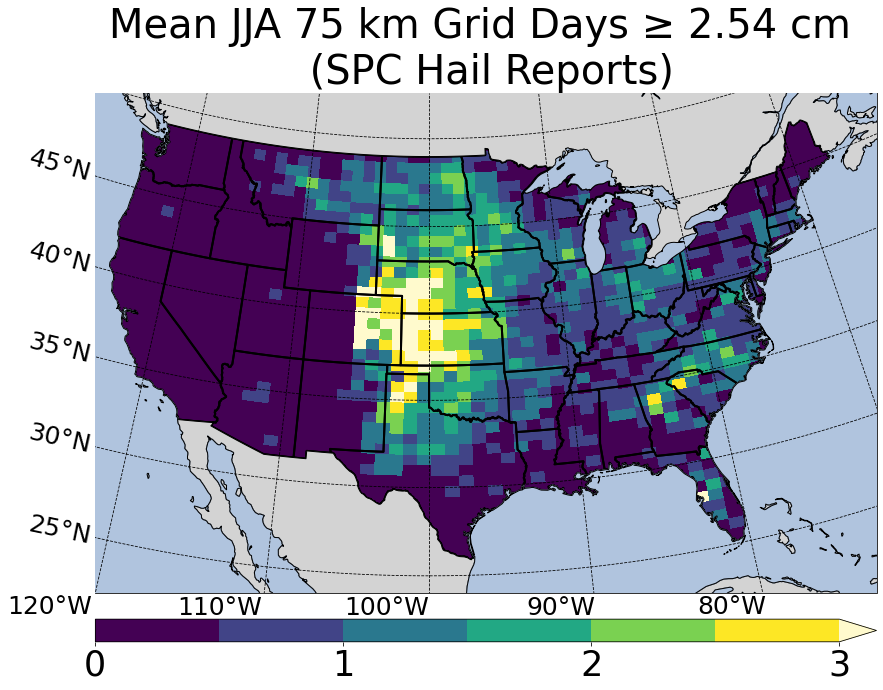

In [43]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

fig = plt.figure(figsize= (14,10)) #Plot a figure
gs1 = gridspec.GridSpec(2, 1, height_ratios=[1, .04], bottom=.05, top=.95, wspace=.1)
map_proj = ccrs.LambertConformal(central_longitude = -100, central_latitude = 35) #Set projection, central lat/lon
ax = plt.subplot(projection = map_proj)
ax.add_feature(cfeature.LAND.with_scale('10m')) #Add land
countries_shp = shpreader.natural_earth(resolution='50m',
                                     category='cultural',
                                     name='admin_0_countries')
for country, info in zip(shpreader.Reader(countries_shp).geometries(), 
                             shpreader.Reader(countries_shp).records()):
        if info.attributes['NAME_LONG'] != 'United States':

            ax.add_geometries([country], ccrs.PlateCarree(),
                             facecolor='lightgrey', edgecolor='k', zorder=6)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='k', 
                                                facecolor='None'), zorder=8) 
ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth = 2) #Add state borders
ax.add_feature(cfeature.STATES.with_scale('10m'), facecolor = 'none', linewidth = 2) #Add US states
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', 
                                                facecolor='lightsteelblue'), zorder=6)
lakes_shp = shpreader.natural_earth(resolution='50m',
                                     category='physical',
                                     name='lakes')
for lake, info in zip(shpreader.Reader(lakes_shp).geometries(), 
                             shpreader.Reader(lakes_shp).records()):
        name = info.attributes['name']
        if name == 'Lake Superior' or name == 'Lake Michigan' or \
           name == 'Lake Huron' or name == 'Lake Erie' or name == 'Lake Ontario':
            
            ax.add_geometries([lake], ccrs.PlateCarree(),
                             facecolor='lightsteelblue', edgecolor='k', zorder=6)
ax.set_extent([240,287,22,50]) #Set lat/lon boundaries
cmap = cm.get_cmap('viridis')
cmap.set_over('lemonchiffon')
levels = np.arange(0, 3.5, 0.5)
lrFig = ax.pcolormesh(lon_bins_2d, lat_bins_2d, mean_days_per_yr, vmax = 3.5, transform = ccrs.PlateCarree(), cmap=cmap, vmin=levels[1], norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, 
                                                                                                                                    clip=False))
gls = ax.gridlines(draw_labels=True, dms = True, x_inline=False, y_inline=False, color="black", linestyle="dashed", zorder = 10)
gls.top_labels=False
gls.right_labels=False
gls.xlabel_style = {'size': 25, 'rotation': 0}
gls.xpadding = 15.0
gls.ylabel_style = {'size': 25}
plt.title("Mean JJA 75 km Grid Days ≥ 2.54 cm \n (SPC Hail Reports)", fontsize = 40)
ax1 = plt.subplot(gs1[1, 0])
cb = plt.colorbar(lrFig, cax = ax1, ticks = [0, 1, 2, 3], orientation = 'horizontal', extend = 'max')
#cb.set_label('Days', fontsize = 30)
cb.ax.tick_params(labelsize = 35)
plt.subplots_adjust(bottom=0.05)
#plt.savefig('/home/scratch/jgoodin/compare_wrf_mesh/use_these_figures/mean_JJA_75km_gridded_sev_hail_report_days_ACTUAL.png') #**Make sure to save results to png!**